In [1]:
import sys, os 
sys.path.append(os.path.abspath('C:/Users/Yazeed/Desktop/workspace/flexaibuild'))

In [2]:
import shutil
from pathlib import Path

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

from flexai import Learner, ActivationStatsManger # type: ignore
from utils import filetools

In [3]:
url_dataset = "https://www.kaggle.com/api/v1/datasets/download/cashbowman/ai-generated-images-vs-real-images?datasetVersionNumber=1"
path_dataset = Path('data')
if not path_dataset.exists():
    path_comp = filetools.download_file(url_dataset, path_dataset)
    filetools.uncompress_and_remove(path_comp)
    folders = ['AiArtData', 'RealArt']
    labels = ['Ai', 'Real']
    for folder, label in zip(folders, labels):
        shutil.move(path_dataset / folder / folder, path_dataset / label)
        shutil.rmtree(path_dataset/ folder)

In [4]:
root_ds = ImageFolder(
    path_dataset,
    transform= transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((224,224), antialias=True),
    ])
)
train_ds, valid_ds, test_ds = torch.utils.data.random_split(root_ds, [0.8, 0.1, 0.1])

dataloaders = {
    'train': DataLoader(train_ds, batch_size=32, shuffle=True),
    'valid': DataLoader(valid_ds, batch_size=32, shuffle=False),
    'test': DataLoader(test_ds, batch_size=32, shuffle=False),
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'

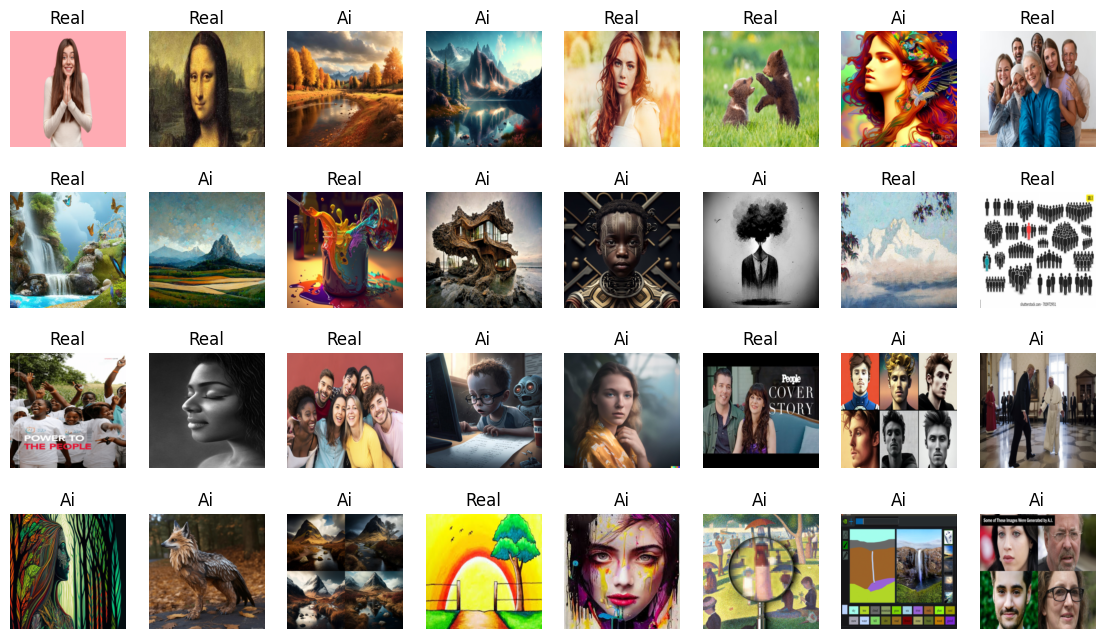

In [5]:
from flexai.vision.utils import image_grid # type: ignore

images, labels = next(iter(dataloaders['train']))
image_grid(images, labels, {v:k for k,v in root_ds.class_to_idx.items()}, figsize=(14,8))

In [6]:
import flexai.vision.transforms as transforms_fai # type: ignore

tfs = {
    'train': transforms.Compose([
        transforms.RandomChoice([
            transforms.CenterCrop(200),
            transforms.CenterCrop(180),
            transforms.CenterCrop(160),
        ]
        ),
        transforms.RandomGrayscale(),
        transforms.RandomChoice([
            transforms.RandomErasing(),
            transforms_fai.RandomNoise(scales=[0.4, 0.4]),
        ]
        ),
    ]
    ),
}

In [7]:
from torch.optim import SGD
from torch.nn import Sequential, Dropout
from torch.nn import CrossEntropyLoss
from torcheval.metrics.functional import multiclass_accuracy
from flexai.modules import DenseLayer # type: ignore
from flexai.callbacks import LRFinderCB, TransformCB, LoggerCB, MetricPlotterCB, ForwardHookCB, LSUVCB # type: ignore

from torch.nn.init import constant_, xavier_uniform_

def output_init(w, b):
  xavier_uniform_(w)
  constant_(b, 0.01)

from torchvision.models import resnet18

model = resnet18(pretrained=True)
in_features = model.fc.in_features
for module in model.modules():
  freeze = False if (type(module).__name__ == 'BatchNorm2d') else True
  module.requires_grad_(freeze)
  
model.fc = Sequential(
  Dropout(),
  DenseLayer(in_features, 2, act=None, init_func=output_init),
)

model.to(device)
metrics = {'loss': CrossEntropyLoss(), 'accuracy': multiclass_accuracy}
optimizer = SGD(model.parameters(), lr=1e-3, weight_decay=0.1)

c:\Users\Yazeed\Desktop\workspace\ai_detector\env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Yazeed\Desktop\workspace\ai_detector\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


c:\Users\Yazeed\Desktop\workspace\ai_detector\env\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
C:\Users\Yazeed\Desktop\workspace\flexaibuild\flexai\callbacks.py:222: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any u

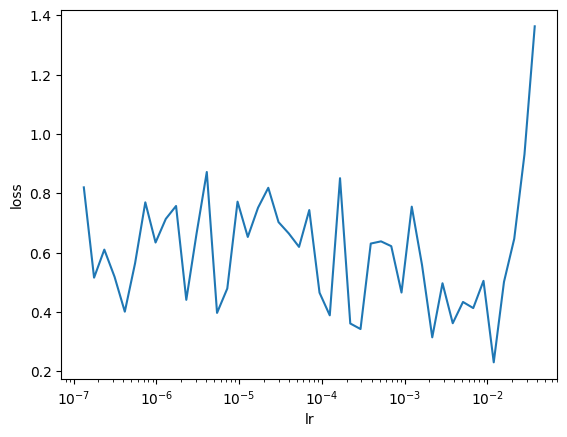

In [8]:
from torch.optim.lr_scheduler import ExponentialLR
lr_scheduler = ExponentialLR(optimizer, gamma=1.33)
Learner(
    model,
    dataloaders,
    optimizer,
    metrics,
    callbacks=[
        LRFinderCB(lr_scheduler, start_lr=1e-7, max_lr=1, break_f=5),
        TransformCB(transform=tfs['train'], phase='train'),
    ],
    device=device,
).fit(3)

In [9]:
for g in optimizer.param_groups:
    g['lr'] = 1e-3

In [10]:
manager = ActivationStatsManger(model, ['ResLayer', 'DenseLayer'])
learner = Learner(
    model,
    dataloaders,
    optimizer,
    metrics,
    callbacks=[
        TransformCB(transform=tfs['train'], phase='train'),
        LoggerCB(),
        MetricPlotterCB(),
        ForwardHookCB(manager.register_stats),
    ],
    device=device
)

Epoch: 6 | loss_train: 0.09689 | loss_valid: 0.2071 | accuracy_train: 0.9615 | accuracy_valid: 0.9297
Epoch: 7 | loss_train: 0.05512 | loss_valid: 1.082 | accuracy_train: 0.9838 | accuracy_valid: 0.6094
Epoch: 8 | loss_train: 0.04901 | loss_valid: 0.3676 | accuracy_train: 0.9814 | accuracy_valid: 0.9062
Epoch: 9 | loss_train: 0.02571 | loss_valid: 0.316 | accuracy_train: 0.9912 | accuracy_valid: 0.9141
Epoch: 10 | loss_train: 0.04745 | loss_valid: 0.2818 | accuracy_train: 0.9812 | accuracy_valid: 0.9453


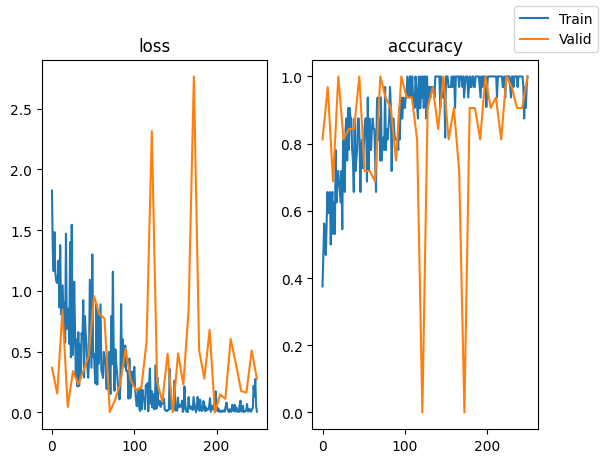

In [14]:
learner.fit(5)

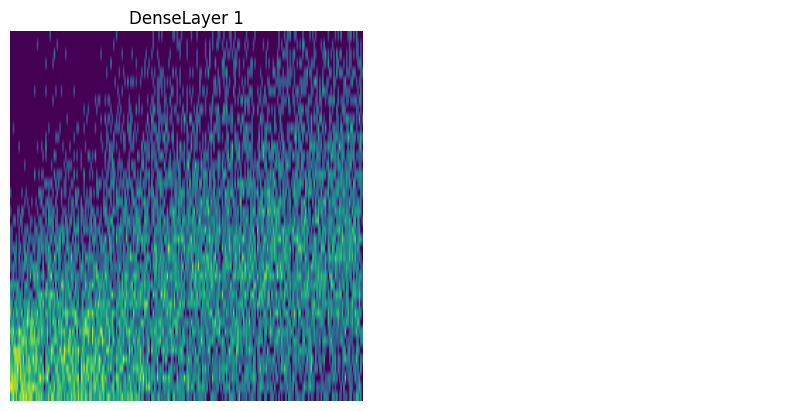

In [15]:
manager.color_dim()

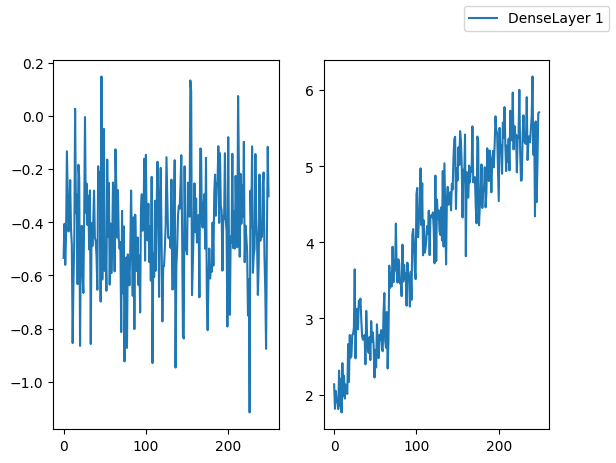

In [16]:
manager.mean_std()

In [18]:
save_path = 'trained-model'
os.mkdir(save_path)
torch.save(model.state_dict(), f'{save_path}/model_last.pt')
torch.save(optimizer.state_dict(), f'{save_path}/optimizer_last.pt')